# Model for aimpoint drift (aka ACA alignment drift) 2021-01

This notebook documents and computes fit coefficients for a simple model that
gives the relative ACA alignment as a linear function of the ACA CCD temperature.
It also includes validation of the implementation of the new model in the
`chandra_aca.drift` package.

## NOTE (Jan 2, 2021): no action required

TA re-ran this notebook and found that the best-fit jumps in DY, DZ are less
than one arcsec and therefore no action is required. There was about 2 arcsec
from the 2020:145 safe mode, but after the IRU gyro swap it was reduced.

## Summary (not updated from previous version)

This is based on the origin `fit_aimpoint_drift` notebook but updated through
2020:190 to include data from after the 2020:145 safe mode normal sun dwell.
One jump was added to the model corresponding to the 2020:145 safe mode.

The ACA alignment is measured accurately for each science observation via the apparent
positions of the fid lights.  These are referred to by their CXC aspect solution
designation as the SIM DY and DZ offsets.  This is actually a misnomer based on
the pre-launch understanding of what physical mechanism would generate such offsets.
We now know via HRMA optical axis measurements that a temperature-dependent change 
in the ACA boresight alignment is responsible.  The HRMA to SIM alignment is quite
stable.

The ACA alignment relates directly to the X-ray detector aimpoint that is used in
observation planning and analysis.  With this model it will be possible to improve
the aimpoint accuracy by introducing a dynamic pointing offset based on the
predicted ACA CCD temperature for each observation.

The model is
```
DY/Z = (t_ccd - offset) * scale + (year - 2016.0) * trend + JUMPS
```
where
```
  t_ccd : ACA CCD temperature (degF)
  scale : scaling in arcsec / degF
  offset : ACA CCD temperature corresponding to DY/Z = 0.0 arcsec
  trend : Trend in DY/Z (arcsec / year)
  year : decimal year
  jumpYYYYDDD : step function from 0.0 to jumpYYYYDDD (arcsec) for date > YYYY:DDD
```
The jumps are persistent step function changes in alignment that have been observed following
extended dwells at normal sun where the ACA gets substantially hotter than during
normal operations.  The exact mechanism is not understood, but could be due to
a non-linear stiction release of a stress point that impacts alignment.

Note that the ACA alignment has a direct linear correlation to the ACA housing temperature (AACH1T).
However, in this model we use the ACA CCD temperature as the model dependent variable because it
is linearly related to housing temperature (AACCDPT = m * AACH1T + b) as long as the TEC is at
max drive current. Since there is already
an existing Xija model to predict ACA CCD temperature this reduces duplication.

This model was fitted to data from 2012:180 to 2020:190 using Sherpa.  The key fit results are:
```
DY
-----
scale = 2.1 arcsec / degF = 3.9 arcsec / degC
trend = -0.95 arcsec / year
jumps ~ -2 to -13 arcsec

model error = +/- 1.9 arcsec (1st to 99th percentile range)

DZ
-----
scale = 1.0 arcsec / degF = 1.8 arcsec / degC
trend = -0.09 arcsec / year
jumps ~ -0.4 to -6.1 arcsec

model error = +/- 2.6 arcsec (1st to 99th percentile range)

```

The model accuracy will be degraded somewhat when ACA CCD temperature
is taken from a predictive Xija model instead of from telemetry.

*This notebook lives in the **aimpoint_mon** project repository*

## Code

In [1]:
import re
import os
# See https://stackoverflow.com/questions/59119396/
# how-to-use-django-3-0-orm-in-a-jupyter-notebook-without-triggering-the-async-con
# os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import sys

import tables
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from astropy.table import Table
import Ska.engarchive.fetch_eng as fetch
from Ska.engarchive import fetch_sci
from Chandra.Time import DateTime
from Ska.Numpy import interpolate
from kadi import events
from sherpa import ui
from Ska.Matplotlib import plot_cxctime

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


<frozen importlib._bootstrap>:219: RuntimeWarning: Unable to load the ciao_version module to determine version number- defaulting 'group' version to 0.0.0


In [2]:
sys.version

'3.8.3 (default, Jul  2 2020, 11:26:31) \n[Clang 10.0.0 ]'

In [3]:
%matplotlib inline

In [4]:
SIM_MM_TO_ARCSEC = 20.493

In [5]:
# Discrete jumps after 2012:001.  Note also jumps at:
#   '2008:293',  # IU-reset
#   '2010:151',  # IU-reset
#   '2011:190',  # Safe mode
JUMPS = ['2015:006',  # IU-reset
         '2015:265',  # Safe mode 6
         '2016:064',  # Safe mode 7
         '2017:066',  # NSM
         '2018:285',  # Safe mode 8
         '2020:146',  # Safe mode 9
         ]

In [6]:
ltt_bads = events.ltt_bads(pad=(0, 200000))
normal_suns = events.normal_suns(pad=(0, 100000))
safe_suns = events.safe_suns(pad=(0, 86400 * 7))

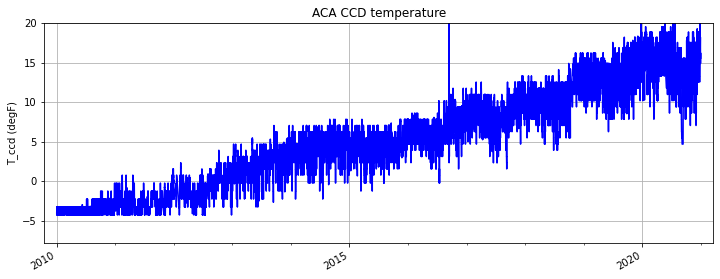

In [7]:
# Aspect camera CCD temperature trend since 2010
t_ccd = fetch.Msid('aacccdpt', start='2010:001', stat='5min')
t_ccd.remove_intervals(ltt_bads | normal_suns | safe_suns)
plt.figure(figsize=(12, 4.5))
t_ccd.plot()
plt.ylabel('T_ccd (degF)')
plt.title('ACA CCD temperature')
plt.ylim(None, 20)
plt.grid()

In [8]:
# Get aspect solution DY and DZ (apparent SIM offsets via fid light positions)
# which are sampled at 1 ksec intervals and updated daily.
if 'adat' not in globals():
    h5 = tables.open_file(f'{os.environ["SKA"]}/data/aimpoint_mon/aimpoint_asol_values.h5')
    adat = h5.root.data[:]
    h5.close()

    adat.sort(order=['time'])

    # Filter bad data when asol DY and DZ are both exactly 0.0 (doesn't happen normally)
    bad = (adat['dy'] == 0.0) & (adat['dz'] == 0.0)
    adat = adat[~bad]

In [9]:
class AcaDriftModel(object):
    """
    Class to encapsulate necessary data and compute the model of ACA
    alignment drift.  The object created from this class is called
    by Sherpa as a function during fitting.  This gets directed to
    the __call__() method.
    """
    YEAR0 = 2016.0  # Reference year for linear offset
    
    def __init__(self, adat, start='2012:001', stop=None):
        """
        adat is the raw data array containing aspect solution data
        sampled at 1 ksec intervals.
        """
        # Get the ACA CCD temperature telemetry
        t_ccd = fetch.Msid('aacccdpt', stat='5min', start=start, stop=stop)
        
        # Slice the ASOL data corresponding to available ACA CCD temps
        i0, i1 = np.searchsorted(adat['time'], [t_ccd.times[0], t_ccd.times[-1]])
        self.asol = adat[i0:i1].copy()
        
        # Convert from mm to arcsec for convenience
        self.asol['dy'] *= SIM_MM_TO_ARCSEC
        self.asol['dz'] *= SIM_MM_TO_ARCSEC
        
        self.times = self.asol['time']
        self.years = Time(self.times, format='cxcsec').decimalyear
        self.years_0 = self.years - self.YEAR0
        
        # Resample CCD temp. data to the 1 ksec ASOL time stamps
        self.t_ccd = interpolate(t_ccd.vals, t_ccd.times, self.asol['time'], method='linear')
        
        # Get indices corresponding to jump times for later model computation
        self.jump_times = Time(JUMPS).cxcsec
        self.jump_idxs = np.searchsorted(self.times, self.jump_times)

    def __call__(self, pars, years=None, t_ccd=None):
        """
        Calculate model prediction for DY or DZ.  Params are:
        
          scale : scaling in arcsec / degF
          offset : ACA CCD temperature corresponding to DY/Z = 0.0 arcsec
          trend : Trend in DY/Z (arcsec / year)
          jumpYYYYDDD : discrete jump in arcsec at date YYYY:DDD
        """
        # Sherpa passes the parameters as a list
        scale, offset, trend = pars[0:3]
        jumps = pars[3:]
        
        # Allow for passing in a different value for ACA CCD temperature
        if t_ccd is None:
            t_ccd = self.t_ccd

        # Compute linear part of model
        out = (t_ccd - offset) * scale + self.years_0 * trend

        # Put in the step function jumps
        for jump_idx, jump in zip(self.jump_idxs, jumps):
            if jump_idx > 10 and jump_idx < len(out) - 10:
                out[jump_idx:] += jump

        return out

In [10]:
def fit_aimpoint_aca_temp(axis='dy', start='2012:180', stop=None):
    """
    Use Sherpa to fit the model parameters
    """
    # Create the object used to define the Sherpa user model, then
    # load as a model and create parameters
    aca_drift = AcaDriftModel(adat, start, stop)
    ui.load_user_model(aca_drift, 'aca_drift_model')
    parnames = ['scale', 'offset', 'trend']
    parnames += ['jump{}'.format(re.sub(':', '', x)) for x in JUMPS]
    ui.add_user_pars('aca_drift_model', parnames)
    
    # Sherpa automatically puts 'aca_drift_model' into globals, but
    # make this explicit so code linters don't complain.
    aca_drift_model = globals()['aca_drift_model']

    # Get the DY or DZ values and load as Sherpa data
    dyz = aca_drift.asol[axis]
    ui.load_arrays(1, aca_drift.years, dyz)

    # Set the model and fit using Simplex (Nelder-Mead) minimization
    ui.set_model(1, aca_drift_model)
    ui.set_method('simplex')
    ui.fit(1)
    
    return aca_drift, ui.get_fit_results()    

In [11]:
def plot_aimpoint_drift(axis, aca_drift, fit_results, start='2010:001', stop=None, plot_t_ccd=False):
    """
    Plot our results
    """
    y_start = DateTime(start).frac_year
    y_stop = DateTime(stop).frac_year
    years = aca_drift.years
    ok = (years > y_start) & (years < y_stop)
    years = aca_drift.years[ok]
    times = aca_drift.times[ok]

    # Call model directly with best-fit parameters to get model values
    dyz_fit = aca_drift(fit_results.parvals)[ok]

    # DY or DZ values from aspect solution
    dyz = aca_drift.asol[axis][ok]
    dyz_resid = dyz - dyz_fit
    
    if plot_t_ccd:
        plt.figure(figsize=(12, 4.5))
        plt.subplot(1, 2, 1)

    plot_cxctime(times, dyz, label='Data')
    plot_cxctime(times, dyz_fit, 'r-', alpha=0.5, label='Fit')
    plot_cxctime(times, dyz_resid, 'r-', label='Residual')
    plt.title('Fit aspect solution {} to scaled ACA CCD temperature'
              .format(axis.upper()))
    plt.ylabel('{} (arcsec)'.format(axis.upper()))
    plt.grid()
    plt.legend(loc='upper left', framealpha=1.0)
    
    if plot_t_ccd:
        dat = fetch_sci.Msid('aacccdpt', start, stop, stat='5min')
        plt.subplot(1, 2, 2)
        dat.plot()
        plt.grid()
        plt.ylabel('AACCCDPT (degC)')
        if isinstance(plot_t_ccd, tuple):
            plt.ylim(*plot_t_ccd)
    
    std = dyz_resid.std()
    p1, p99 = np.percentile(dyz_resid, [1, 99])
    print('Fit residual stddev = {:.2f} arcsec'.format(std))
    print('Fit residual 99th - 1st percentile = {:.2f}'.format(p99 - p1))

## Fit model coefficients for DY and plot results

In [12]:
aca_drift_dy, fit_dy = fit_aimpoint_aca_temp('dy')

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 2.17448e+06
Final fit statistic   = 5975.29 at function evaluation 2446
Data points           = 201691
Degrees of freedom    = 201682
Probability [Q-value] = 1
Reduced statistic     = 0.0296273
Change in statistic   = 2.16851e+06
   aca_drift_model.scale   2.08551     
   aca_drift_model.offset   -6.51984    
   aca_drift_model.trend   -0.861034   
   aca_drift_model.jump2015006   -4.90313    
   aca_drift_model.jump2015265   -4.73203    
   aca_drift_model.jump2016064   -1.89971    
   aca_drift_model.jump2017066   -1.89925    
   aca_drift_model.jump2018285   -12.0525    
   aca_drift_model.jump2020146   -0.891698   


Fit residual stddev = 0.85 arcsec
Fit residual 99th - 1st percentile = 3.86


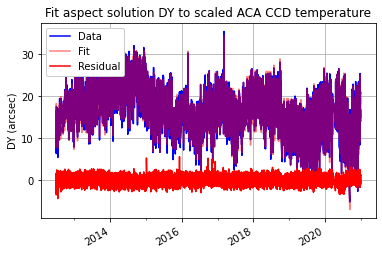

In [13]:
plot_aimpoint_drift('dy', aca_drift_dy, fit_dy)

## Zoom in around the 2020:145 safe mode time

Fit residual stddev = 0.97 arcsec
Fit residual 99th - 1st percentile = 4.24


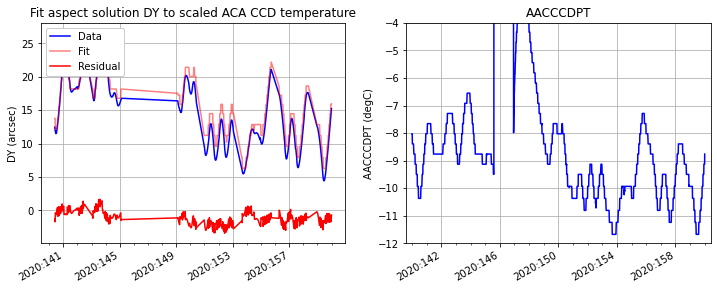

In [14]:
start = '2020:140'
stop = '2020:160'
plot_aimpoint_drift('dy', aca_drift_dy, fit_dy, start=start, stop=stop, plot_t_ccd=(-12, -4))

### Illustrate model behavior by assuming a constant ACA CCD temperature

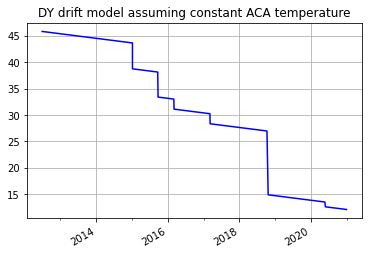

In [15]:
dyz_fit = aca_drift_dy(fit_dy.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dy.times, dyz_fit)
plt.title('DY drift model assuming constant ACA temperature')
plt.grid();

## Fit model coefficients for DZ and plot results

In [16]:
aca_drift_dz, fit_dz = fit_aimpoint_aca_temp('dz')

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 2.52789e+06
Final fit statistic   = 13107.9 at function evaluation 3910
Data points           = 201691
Degrees of freedom    = 201682
Probability [Q-value] = 1
Reduced statistic     = 0.0649929
Change in statistic   = 2.51478e+06
   aca_drift_model.scale   0.966609    
   aca_drift_model.offset   -16.9323    
   aca_drift_model.trend   -0.0464661  
   aca_drift_model.jump2015006   -2.22384    
   aca_drift_model.jump2015265   -0.386194   
   aca_drift_model.jump2016064   -0.933285   
   aca_drift_model.jump2017066   -0.915363   
   aca_drift_model.jump2018285   -5.14403    
   aca_drift_model.jump2020146   -0.555511   


Fit residual stddev = 1.40 arcsec
Fit residual 99th - 1st percentile = 5.71


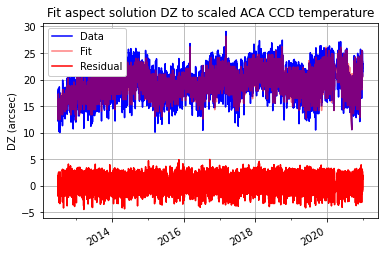

In [17]:
plot_aimpoint_drift('dz', aca_drift_dz, fit_dz)

Fit residual stddev = 1.15 arcsec
Fit residual 99th - 1st percentile = 4.90


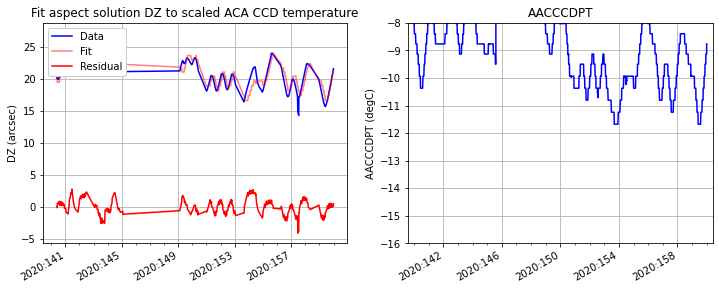

In [18]:
start = '2020:140'
stop = '2020:160'
plot_aimpoint_drift('dz', aca_drift_dz, fit_dz, start=start, stop=stop, plot_t_ccd=(-16, -8))

### Illustrate model behavior by assuming a constant ACA CCD temperature

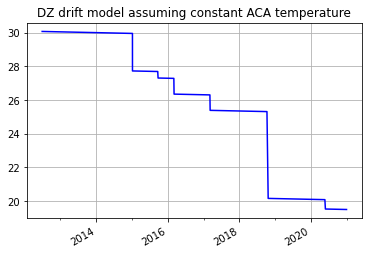

In [19]:
dyz_fit = aca_drift_dz(fit_dz.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dz.times, dyz_fit)
plt.title('DZ drift model assuming constant ACA temperature')
plt.grid();

## Comparison to current flight model for NOV0518B

Compare the actual flight `aca_offset_y/z` from the `*_dynamical_offsets.txt` files
to predictions with the new `chandra_aca.drift` module.

A key point is to use the observed mean `T_ccd` with the new model to be able to reproduce
the observed aimpoint shift of about 8 arcsec.  The jump was 13 arcsec but we did not
see that directly because of the ~1.4 C error in the temperatures being used to
predict the aimpoint offset.

In [20]:
text = """
obsid detector  chipx   chipy  chip_id aca_offset_y aca_offset_z mean_t_ccd       mean_date      
----- -------- ------- ------- ------- ------------ ------------ ---------- ---------------------
21152   ACIS-S   210.0   520.0       7         -0.9       -22.67     -11.72 2018:307:18:07:54.816
20332   ACIS-I   970.0   975.0       3       -14.27       -21.89     -11.88 2018:308:04:03:46.816
21718    HRC-I  7590.0  7745.0       0       -13.39        -22.8     -11.53 2018:313:03:14:10.816
21955   HRC-S  2195.0  8915.0        2       -12.50        -22.57    -11.53 2018:305:16:28:34.816  
"""
obss = Table.read(text, format='ascii.fixed_width_two_line')

In [21]:
import sys
import os
sys.path.insert(0, os.path.join(os.environ['HOME'], 'git', 'chandra_aca'))
import chandra_aca
from chandra_aca import drift
from kadi import events

In [22]:
chandra_aca.test(get_version=True)

'4.31.1.dev14+gf601104-r479-f601104'

In [23]:
for obs in obss:
    dwell = events.dwells.filter(obsid=21152)[0]
    t_ccd = fetch_sci.Msid('aacccdpt', dwell.start, dwell.stop, stat='5min')
    mean_t_ccd = np.mean(t_ccd.vals)
    offsets = drift.get_aca_offsets(obs['detector'], chip_id=obs['chip_id'],
                                    chipx=obs['chipx'], chipy=obs['chipy'], 
                                    time=obs['mean_date'], t_ccd=mean_t_ccd)
    print(obs)
    print('T_ccd:', mean_t_ccd, '  Delta offsets Y Z:',
          '%.2f' % (obs['aca_offset_y'] - offsets[0]), 
          '%.2f' % (obs['aca_offset_z'] - offsets[1]))
    print()

obsid detector chipx chipy chip_id aca_offset_y aca_offset_z mean_t_ccd       mean_date      
----- -------- ----- ----- ------- ------------ ------------ ---------- ---------------------
21152   ACIS-S 210.0 520.0       7         -0.9       -22.67     -11.72 2018:307:18:07:54.816
T_ccd: -10.37207   Delta offsets Y Z: -8.27 -3.92

obsid detector chipx chipy chip_id aca_offset_y aca_offset_z mean_t_ccd       mean_date      
----- -------- ----- ----- ------- ------------ ------------ ---------- ---------------------
20332   ACIS-I 970.0 975.0       3       -14.27       -21.89     -11.88 2018:308:04:03:46.816
T_ccd: -10.37207   Delta offsets Y Z: -7.64 -3.61

obsid detector chipx  chipy  chip_id aca_offset_y aca_offset_z mean_t_ccd       mean_date      
----- -------- ------ ------ ------- ------------ ------------ ---------- ---------------------
21718    HRC-I 7590.0 7745.0       0       -13.39        -22.8     -11.53 2018:313:03:14:10.816
T_ccd: -10.37207   Delta offsets Y Z: -9.00 -4

## Comparison of local model prediction to implementation in chandra_aca

In [24]:
from chandra_aca.tests.test_all import simple_test_aca_drift

In [25]:
dy, dz, times = simple_test_aca_drift()

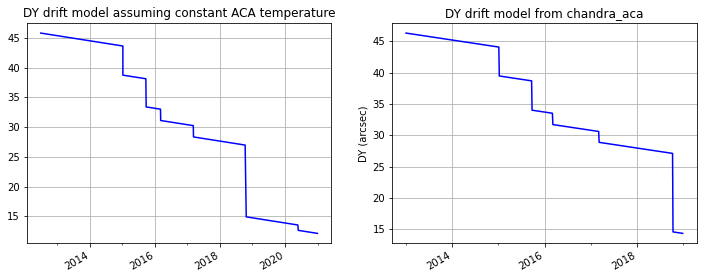

In [26]:
plt.figure(figsize=(12, 4.5))
plt.subplot(1, 2, 1)
dy_fit = aca_drift_dy(fit_dy.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dy.times, dy_fit)
plt.title('DY drift model assuming constant ACA temperature')
plt.grid();

plt.subplot(1, 2, 2)
plot_cxctime(times, dy);
plt.grid()
plt.ylabel('DY (arcsec)');
plt.title('DY drift model from chandra_aca');

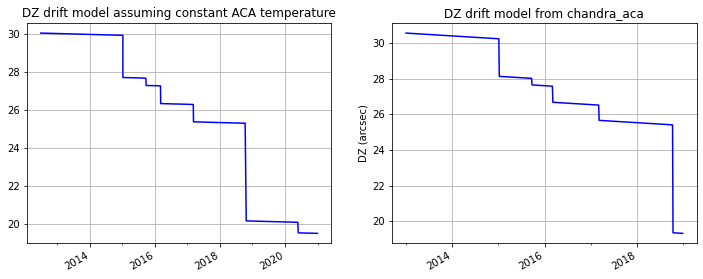

In [27]:
plt.figure(figsize=(12, 4.5))
plt.subplot(1, 2, 1)
dz_fit = aca_drift_dz(fit_dz.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dz.times, dz_fit)
plt.title('DZ drift model assuming constant ACA temperature')
plt.grid();

plt.subplot(1, 2, 2)
plot_cxctime(times, dz);
plt.grid()
plt.ylabel('DZ (arcsec)');
plt.title('DZ drift model from chandra_aca');